# Design of Experiments: Part 5 - Optimal Designs

## Introduction

Optimal designs are computer-generated experimental designs that optimize specific statistical criteria. Unlike classical designs with predetermined structures, optimal designs are tailored to specific experimental situations.

In this notebook, we'll explore:
1. **D-Optimal Design** - Minimizes the determinant of (X'X)^(-1)
2. **A-Optimal Design** - Minimizes the trace of (X'X)^(-1)
3. **G-Optimal Design** - Minimizes maximum prediction variance
4. **I-Optimal Design** - Minimizes average prediction variance
5. **Custom Constraints** - Handling irregular design regions

### When to Use Optimal Designs:
- Non-standard experimental regions
- Limited budget (need fewer runs than classical designs)
- Mixture experiments
- Constrained factor spaces
- Augmenting existing designs

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize, differential_evolution
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import itertools
from pyDOE3 import fullfact, fracfact, ccdesign
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.3.4
Pandas version: 2.3.3


## 1. Load and Prepare E-commerce Data

In [3]:
# Load the e-commerce dataset
data = pd.read_csv('DOE_Simulator/data/raw/ecommerce_data.csv')

# Display basic information
print("Dataset Shape:", data.shape)
print("\nFirst few rows:")
data.head()

Dataset Shape: (20000, 24)

First few rows:


,customer_id,age,gender,location,income_level,education,account_age_days,total_orders,avg_order_value,last_order_days_ago,...,loyalty_program_member,customer_service_interactions,cart_abandonment_rate,review_count,avg_rating_given,social_media_follower,conversion_rate,lifetime_value,churn_probability,response_to_marketing
0,CUST000001,43,Male,Urban,High,PhD,259,3,171.83,101,...,No,0.0,38.1,1.0,4.3,No,40.9,578.43,31.2,1
1,CUST000002,36,Non-binary,Urban,High,PhD,165,3,104.90,151,...,No,0.0,40.8,0.0,3.3,Yes,32.0,358.51,49.8,1
2,CUST000003,45,Female,Suburban,Medium,Bachelor,572,11,14.55,356,...,No,0.0,28.9,3.0,3.6,No,25.6,178.54,87.0,0
3,CUST000004,56,Female,Suburban,Medium,Bachelor,624,10,71.30,49,...,No,0.0,30.2,1.0,4.7,No,28.1,788.93,39.1,1
4,CUST000005,35,Female,Suburban,High,Master,1079,20,150.87,2,...,No,1.0,37.0,5.0,3.8,No,54.6,3328.80,35.8,1


In [4]:
# Define factors for optimal design experiments
# We'll use a mix of continuous and categorical factors
factors_optimal = {
    'discount_rate': {'type': 'continuous', 'range': [0, 40], 'description': 'Discount percentage'},
    'free_shipping_threshold': {'type': 'continuous', 'range': [0, 100], 'description': 'Min order for free shipping ($)'},
    'homepage_design': {'type': 'categorical', 'levels': ['A', 'B', 'C'], 'description': 'Homepage variant'},
    'email_time': {'type': 'categorical', 'levels': ['Morning', 'Afternoon', 'Evening'], 'description': 'Email send time'},
    'promotion_type': {'type': 'categorical', 'levels': ['Flash', 'Weekly', 'Seasonal'], 'description': 'Promotion type'}
}

# Create synthetic factors if not in dataset
if 'discount_rate' not in data.columns:
    data['discount_rate'] = np.random.uniform(0, 40, len(data))
if 'free_shipping_threshold' not in data.columns:
    data['free_shipping_threshold'] = np.random.uniform(0, 100, len(data))
if 'homepage_design' not in data.columns:
    data['homepage_design'] = np.random.choice(['A', 'B', 'C'], len(data))
if 'email_time' not in data.columns:
    data['email_time'] = np.random.choice(['Morning', 'Afternoon', 'Evening'], len(data))
if 'promotion_type' not in data.columns:
    data['promotion_type'] = np.random.choice(['Flash', 'Weekly', 'Seasonal'], len(data))

# Create response variable
def simulate_sales_response(row):
    """Simulate sales based on factors"""
    # Base sales
    sales = 1000
    
    # Effect of discount (quadratic - too much discount hurts margin)
    sales += 20 * row['discount_rate'] - 0.3 * row['discount_rate']**2
    
    # Effect of free shipping threshold (lower is better)
    sales += 200 * np.exp(-row['free_shipping_threshold']/50)
    
    # Categorical effects
    design_effects = {'A': 0, 'B': 50, 'C': 100}
    sales += design_effects.get(row['homepage_design'], 0)
    
    time_effects = {'Morning': 30, 'Afternoon': 0, 'Evening': 60}
    sales += time_effects.get(row['email_time'], 0)
    
    promo_effects = {'Flash': 80, 'Weekly': 40, 'Seasonal': 60}
    sales += promo_effects.get(row['promotion_type'], 0)
    
    # Add noise
    sales += np.random.normal(0, 50)
    
    return max(0, sales)

data['sales'] = data.apply(simulate_sales_response, axis=1)

print("Factors for Optimal Design:")
for factor, info in factors_optimal.items():
    print(f"  {factor}: {info['description']}")
    print(f"    Type: {info['type']}")
    if info['type'] == 'continuous':
        print(f"    Range: {info['range']}")
    else:
        print(f"    Levels: {info['levels']}")

print(f"\nResponse Variable: Sales")
print(f"  Mean: ${data['sales'].mean():.2f}")
print(f"  Std: ${data['sales'].std():.2f}")

Factors for Optimal Design:
  discount_rate: Discount percentage
    Type: continuous
    Range: [0, 40]
  free_shipping_threshold: Min order for free shipping ($)
    Type: continuous
    Range: [0, 100]
  homepage_design: Homepage variant
    Type: categorical
    Levels: ['A', 'B', 'C']
  email_time: Email send time
    Type: categorical
    Levels: ['Morning', 'Afternoon', 'Evening']
  promotion_type: Promotion type
    Type: categorical
    Levels: ['Flash', 'Weekly', 'Seasonal']

Response Variable: Sales
  Mean: $1466.02
  Std: $132.46


## 2. Understanding Optimality Criteria

Different optimality criteria focus on different aspects of the design quality:

In [5]:
def calculate_information_matrix(X):
    """Calculate the information matrix (X'X)"""
    return X.T @ X

def calculate_optimality_criteria(X, candidate_set=None):
    """Calculate various optimality criteria for a design matrix X"""
    
    # Information matrix
    M = calculate_information_matrix(X)
    n, p = X.shape
    
    # Check if matrix is singular
    try:
        M_inv = np.linalg.inv(M)
        
        # D-optimality: minimize determinant of M^(-1)
        # Equivalent to maximizing determinant of M
        d_opt = np.linalg.det(M) ** (1/p)  # Geometric mean for scaling
        
        # A-optimality: minimize trace of M^(-1)
        a_opt = np.trace(M_inv)
        
        # G-optimality: minimize maximum variance
        # max(diag(X * M^(-1) * X'))
        var_matrix = X @ M_inv @ X.T
        g_opt = np.max(np.diag(var_matrix))
        
        # I-optimality: minimize average prediction variance
        if candidate_set is not None:
            pred_var = np.diag(candidate_set @ M_inv @ candidate_set.T)
            i_opt = np.mean(pred_var)
        else:
            i_opt = np.mean(np.diag(var_matrix))
        
        # E-optimality: maximize minimum eigenvalue of M
        eigenvalues = np.linalg.eigvals(M)
        e_opt = np.min(eigenvalues.real)
        
    except np.linalg.LinAlgError:
        # Singular matrix
        d_opt = a_opt = g_opt = i_opt = e_opt = np.inf
    
    return {
        'D-optimality': d_opt,
        'A-optimality': a_opt,
        'G-optimality': g_opt,
        'I-optimality': i_opt,
        'E-optimality': e_opt
    }

# Demonstrate with a simple example
print("Optimality Criteria Explanation:")
print("="*60)

criteria_explanation = [
    ("D-Optimal", "Minimizes volume of confidence ellipsoid", "Best for parameter estimation"),
    ("A-Optimal", "Minimizes average variance of parameters", "Good for individual parameters"),
    ("G-Optimal", "Minimizes maximum prediction variance", "Best worst-case prediction"),
    ("I-Optimal", "Minimizes average prediction variance", "Best average prediction"),
    ("E-Optimal", "Maximizes minimum eigenvalue", "Improves worst-estimated linear combination")
]

for name, description, use_case in criteria_explanation:
    print(f"\n{name}:")
    print(f"  Description: {description}")
    print(f"  Use case: {use_case}")

Optimality Criteria Explanation:

D-Optimal:
  Description: Minimizes volume of confidence ellipsoid
  Use case: Best for parameter estimation

A-Optimal:
  Description: Minimizes average variance of parameters
  Use case: Good for individual parameters

G-Optimal:
  Description: Minimizes maximum prediction variance
  Use case: Best worst-case prediction

I-Optimal:
  Description: Minimizes average prediction variance
  Use case: Best average prediction

E-Optimal:
  Description: Maximizes minimum eigenvalue
  Use case: Improves worst-estimated linear combination


## 3. D-Optimal Design Algorithm

We'll implement a coordinate exchange algorithm to find D-optimal designs.

In [6]:
class DOptimalDesign:
    """D-Optimal design using coordinate exchange algorithm"""
    
    def __init__(self, candidate_set, model_type='linear', n_runs=None):
        """
        Initialize D-Optimal designer
        
        Parameters:
        - candidate_set: Array of candidate design points
        - model_type: 'linear', 'quadratic', or 'interaction'
        - n_runs: Number of experimental runs (if None, uses heuristic)
        """
        self.candidate_set = candidate_set
        self.model_type = model_type
        self.n_candidates = len(candidate_set)
        
        # Expand candidate set based on model type
        self.X_candidates = self._expand_model_matrix(candidate_set)
        self.n_terms = self.X_candidates.shape[1]
        
        # Set number of runs
        if n_runs is None:
            # Heuristic: 1.5 to 2 times number of model terms
            self.n_runs = min(int(1.5 * self.n_terms), self.n_candidates)
        else:
            self.n_runs = min(n_runs, self.n_candidates)
    
    def _expand_model_matrix(self, X):
        """Expand design matrix based on model type"""
        n_samples, n_features = X.shape
        
        if self.model_type == 'linear':
            # Add intercept
            return np.column_stack([np.ones(n_samples), X])
        
        elif self.model_type == 'interaction':
            # Linear terms + two-way interactions
            poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)
            return poly.fit_transform(X)
        
        elif self.model_type == 'quadratic':
            # Full quadratic model
            poly = PolynomialFeatures(degree=2, include_bias=True)
            return poly.fit_transform(X)
        
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")
    
    def _calculate_d_criterion(self, indices):
        """Calculate D-criterion for given design points"""
        X = self.X_candidates[indices]
        try:
            M = X.T @ X
            return np.linalg.det(M) ** (1/self.n_terms)
        except:
            return -np.inf
    
    def coordinate_exchange(self, n_starts=10, max_iter=100):
        """Find D-optimal design using coordinate exchange algorithm"""
        best_design = None
        best_criterion = -np.inf
        
        for start in range(n_starts):
            # Random initial design
            current_indices = np.random.choice(self.n_candidates, 
                                             self.n_runs, replace=False)
            current_criterion = self._calculate_d_criterion(current_indices)
            
            # Coordinate exchange
            for iteration in range(max_iter):
                improved = False
                
                # Try to exchange each point
                for i in range(self.n_runs):
                    old_index = current_indices[i]
                    
                    # Try all candidate points
                    for new_index in range(self.n_candidates):
                        if new_index not in current_indices:
                            # Try exchange
                            current_indices[i] = new_index
                            new_criterion = self._calculate_d_criterion(current_indices)
                            
                            if new_criterion > current_criterion:
                                current_criterion = new_criterion
                                improved = True
                            else:
                                # Revert
                                current_indices[i] = old_index
                
                if not improved:
                    break
            
            # Update best design
            if current_criterion > best_criterion:
                best_criterion = current_criterion
                best_design = current_indices.copy()
        
        self.optimal_indices = best_design
        self.optimal_criterion = best_criterion
        return best_design
    
    def get_design_matrix(self):
        """Get the optimal design matrix"""
        if self.optimal_indices is None:
            raise ValueError("Run coordinate_exchange first")
        return self.candidate_set[self.optimal_indices]

# Create a candidate set for demonstration
n_levels = 5  # 5 levels per factor
continuous_factors = ['discount_rate', 'free_shipping_threshold']

# Create grid of candidate points
discount_levels = np.linspace(0, 40, n_levels)
shipping_levels = np.linspace(0, 100, n_levels)

candidate_points = []
for d in discount_levels:
    for s in shipping_levels:
        candidate_points.append([d, s])

candidate_set = np.array(candidate_points)

print(f"Candidate set size: {len(candidate_set)} points")
print(f"Factor ranges:")
print(f"  Discount: {candidate_set[:, 0].min():.1f} - {candidate_set[:, 0].max():.1f}%")
print(f"  Free Shipping: ${candidate_set[:, 1].min():.1f} - ${candidate_set[:, 1].max():.1f}")

Candidate set size: 25 points
Factor ranges:
  Discount: 0.0 - 40.0%
  Free Shipping: $0.0 - $100.0


## 4. Generate D-Optimal Designs for Different Models


Generating D-optimal design for linear model...
  Number of model terms: 3
  Number of runs: 4
  D-criterion value: 400.0000

Generating D-optimal design for interaction model...
  Number of model terms: 4
  Number of runs: 6
  D-criterion value: 4997.9988

Generating D-optimal design for quadratic model...
  Number of model terms: 6
  Number of runs: 9
  D-criterion value: 39143.0601


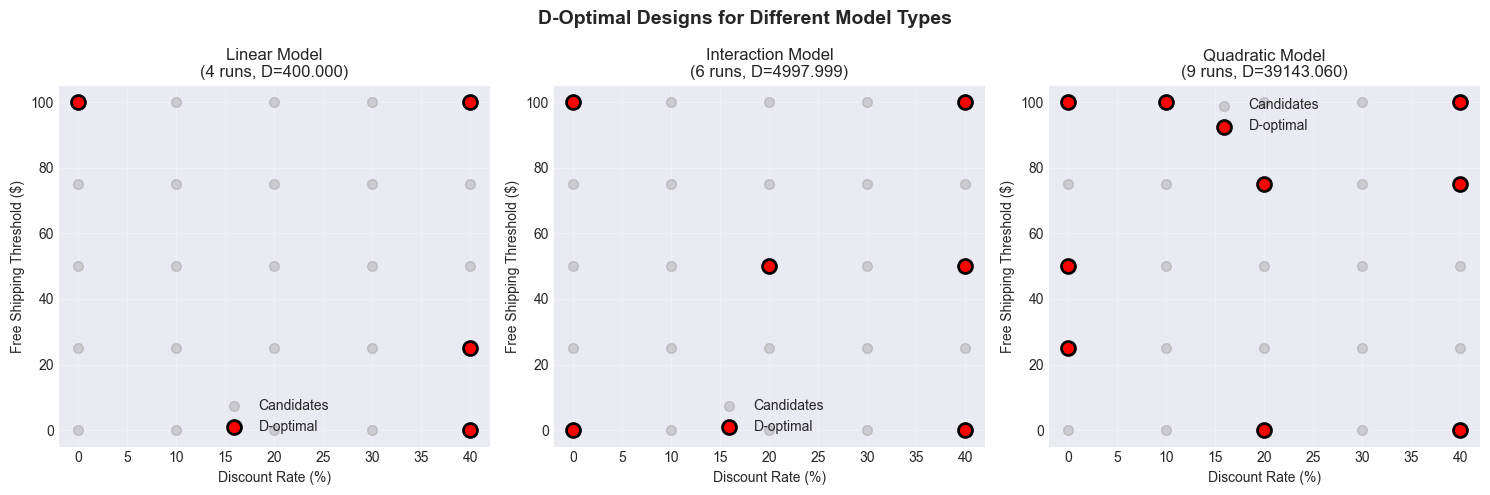

In [7]:
# Generate D-optimal designs for different model types
model_types = ['linear', 'interaction', 'quadratic']
d_optimal_designs = {}

for model_type in model_types:
    print(f"\nGenerating D-optimal design for {model_type} model...")
    
    designer = DOptimalDesign(candidate_set, model_type=model_type)
    optimal_indices = designer.coordinate_exchange(n_starts=5)
    optimal_design = designer.get_design_matrix()
    
    d_optimal_designs[model_type] = {
        'designer': designer,
        'design': optimal_design,
        'n_runs': len(optimal_design),
        'n_terms': designer.n_terms,
        'd_criterion': designer.optimal_criterion
    }
    
    print(f"  Number of model terms: {designer.n_terms}")
    print(f"  Number of runs: {len(optimal_design)}")
    print(f"  D-criterion value: {designer.optimal_criterion:.4f}")

# Visualize the designs
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, model_type in enumerate(model_types):
    ax = axes[idx]
    design = d_optimal_designs[model_type]['design']
    
    # Plot candidate points
    ax.scatter(candidate_set[:, 0], candidate_set[:, 1], 
              alpha=0.3, s=50, color='gray', label='Candidates')
    
    # Plot selected points
    ax.scatter(design[:, 0], design[:, 1], 
              color='red', s=100, edgecolor='black', linewidth=2, 
              label='D-optimal', zorder=5)
    
    ax.set_xlabel('Discount Rate (%)')
    ax.set_ylabel('Free Shipping Threshold ($)')
    ax.set_title(f'{model_type.capitalize()} Model\n({d_optimal_designs[model_type]["n_runs"]} runs, D={d_optimal_designs[model_type]["d_criterion"]:.3f})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('D-Optimal Designs for Different Model Types', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Compare with Classical Designs


Design Comparison (Quadratic Model):
                   D-optimality  A-optimality  G-optimality  I-optimality  E-optimality  n_runs
D-Optimal                 3.477         3.331         0.891         0.667         0.507     9.0
Full Factorial 3²         4.160         2.139         0.806         0.667         1.000     9.0
Central Composite         2.828         3.000         0.625         0.500         1.000    12.0


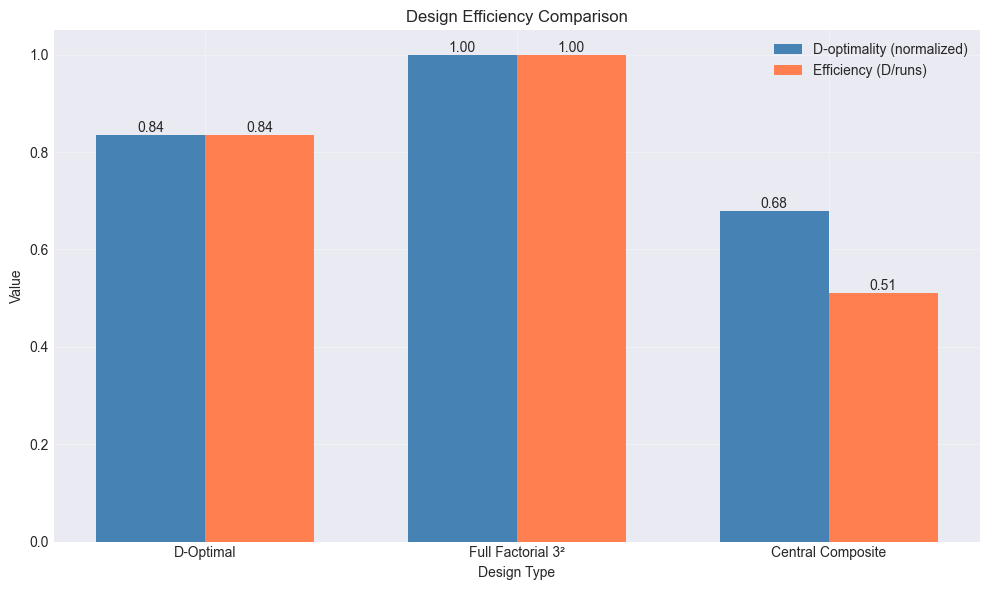

In [8]:
def normalize_design(design, ranges):
    """Normalize design to [-1, 1] coding"""
    normalized = np.zeros_like(design)
    for i, (min_val, max_val) in enumerate(ranges):
        center = (max_val + min_val) / 2
        half_range = (max_val - min_val) / 2
        normalized[:, i] = (design[:, i] - center) / half_range
    return normalized

# Create classical designs for comparison
ranges = [(0, 40), (0, 100)]  # Discount and shipping threshold ranges

# Full factorial 3^2
ff_coded = fullfact([3, 3]) - 1  # Convert to -1, 0, 1 coding
ff_design = np.zeros_like(ff_coded)
for i, (min_val, max_val) in enumerate(ranges):
    center = (max_val + min_val) / 2
    half_range = (max_val - min_val) / 2
    ff_design[:, i] = center + ff_coded[:, i] * half_range

# Central composite design
ccd_coded = ccdesign(2, center=(2, 2), alpha='rotatable', face='circumscribed')
ccd_design = np.zeros_like(ccd_coded)
for i, (min_val, max_val) in enumerate(ranges):
    center = (max_val + min_val) / 2
    half_range = (max_val - min_val) / 2
    ccd_design[:, i] = center + ccd_coded[:, i] * half_range / np.sqrt(2)

# Calculate criteria for all designs
def compare_designs(designs_dict, model_type='quadratic'):
    """Compare multiple designs using various criteria"""
    
    comparison_results = {}
    
    for name, design in designs_dict.items():
        # Normalize design
        design_norm = normalize_design(design, ranges)
        
        # Expand for model
        if model_type == 'quadratic':
            poly = PolynomialFeatures(degree=2, include_bias=True)
            X = poly.fit_transform(design_norm)
        elif model_type == 'linear':
            X = np.column_stack([np.ones(len(design)), design_norm])
        else:
            poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)
            X = poly.fit_transform(design_norm)
        
        # Calculate criteria
        criteria = calculate_optimality_criteria(X)
        criteria['n_runs'] = len(design)
        comparison_results[name] = criteria
    
    return pd.DataFrame(comparison_results).T

# Compare designs
designs_to_compare = {
    'D-Optimal': d_optimal_designs['quadratic']['design'],
    'Full Factorial 3²': ff_design,
    'Central Composite': ccd_design
}

comparison_df = compare_designs(designs_to_compare, model_type='quadratic')

print("\nDesign Comparison (Quadratic Model):")
print("="*60)
print(comparison_df.round(3).to_string())

# Visualize efficiency comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Normalize D-optimality values (higher is better)
d_values = comparison_df['D-optimality'].values
d_normalized = d_values / d_values.max()

# Calculate efficiency relative to number of runs
n_runs = comparison_df['n_runs'].values
efficiency = d_normalized / (n_runs / n_runs.min())

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, d_normalized, width, label='D-optimality (normalized)', color='steelblue')
bars2 = ax.bar(x + width/2, efficiency, width, label='Efficiency (D/runs)', color='coral')

ax.set_xlabel('Design Type')
ax.set_ylabel('Value')
ax.set_title('Design Efficiency Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 6. Optimal Design with Constraints

Real-world experiments often have constraints on the design region.

Constrained Design Region:
  Total candidate points: 200
  Discount range: 0.3 - 39.7%
  Threshold range: $1.0 - $98.8

Constrained D-Optimal Design:
  Number of runs: 12
  D-criterion: 25218.5132


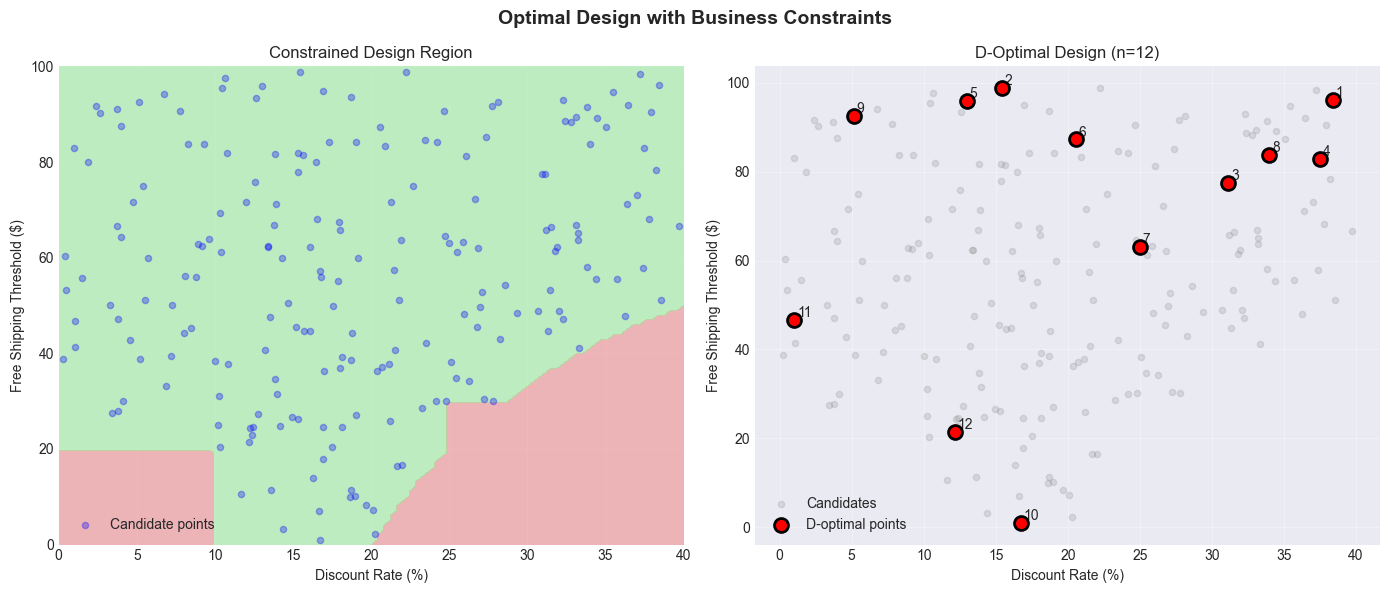

In [9]:
def create_constrained_candidate_set(n_points=100):
    """Create candidate set with realistic business constraints"""
    
    candidates = []
    
    while len(candidates) < n_points:
        # Random point
        discount = np.random.uniform(0, 40)
        threshold = np.random.uniform(0, 100)
        
        # Business constraints:
        # 1. High discount requires high minimum order
        if discount > 25 and threshold < 30:
            continue
        
        # 2. Low threshold incompatible with low discount
        if threshold < 20 and discount < 10:
            continue
        
        # 3. Budget constraint: discount * (100 - threshold) < 2000
        if discount * (100 - threshold) > 2000:
            continue
        
        candidates.append([discount, threshold])
    
    return np.array(candidates)

# Create constrained candidate set
constrained_candidates = create_constrained_candidate_set(200)

print("Constrained Design Region:")
print(f"  Total candidate points: {len(constrained_candidates)}")
print(f"  Discount range: {constrained_candidates[:, 0].min():.1f} - {constrained_candidates[:, 0].max():.1f}%")
print(f"  Threshold range: ${constrained_candidates[:, 1].min():.1f} - ${constrained_candidates[:, 1].max():.1f}")

# Generate D-optimal design for constrained region
constrained_designer = DOptimalDesign(constrained_candidates, 
                                     model_type='quadratic', 
                                     n_runs=12)
constrained_indices = constrained_designer.coordinate_exchange(n_starts=10)
constrained_design = constrained_designer.get_design_matrix()

print(f"\nConstrained D-Optimal Design:")
print(f"  Number of runs: {len(constrained_design)}")
print(f"  D-criterion: {constrained_designer.optimal_criterion:.4f}")

# Visualize constrained design region and optimal points
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Show constraints
ax1 = axes[0]

# Create grid for constraint visualization
discount_grid = np.linspace(0, 40, 100)
threshold_grid = np.linspace(0, 100, 100)
D, T = np.meshgrid(discount_grid, threshold_grid)

# Evaluate constraints
constraint1 = ~((D > 25) & (T < 30))  # High discount requires high threshold
constraint2 = ~((T < 20) & (D < 10))   # Low threshold incompatible with low discount
constraint3 = D * (100 - T) < 2000     # Budget constraint

feasible = constraint1 & constraint2 & constraint3

ax1.contourf(D, T, feasible.astype(float), levels=[0, 0.5, 1], 
            colors=['lightcoral', 'lightgreen'], alpha=0.5)
ax1.scatter(constrained_candidates[:, 0], constrained_candidates[:, 1], 
           alpha=0.3, s=20, color='blue', label='Candidate points')
ax1.set_xlabel('Discount Rate (%)')
ax1.set_ylabel('Free Shipping Threshold ($)')
ax1.set_title('Constrained Design Region')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: D-optimal design
ax2 = axes[1]
ax2.scatter(constrained_candidates[:, 0], constrained_candidates[:, 1], 
           alpha=0.2, s=20, color='gray', label='Candidates')
ax2.scatter(constrained_design[:, 0], constrained_design[:, 1], 
           color='red', s=100, edgecolor='black', linewidth=2, 
           label='D-optimal points', zorder=5)

# Number the design points
for i, (x, y) in enumerate(constrained_design):
    ax2.annotate(str(i+1), (x, y), xytext=(2, 2), textcoords='offset points')

ax2.set_xlabel('Discount Rate (%)')
ax2.set_ylabel('Free Shipping Threshold ($)')
ax2.set_title(f'D-Optimal Design (n={len(constrained_design)})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Optimal Design with Business Constraints', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Other Optimality Criteria: A, G, and I-Optimal

Generating Optimal Designs for Different Criteria:

D-Optimal Design:
  Criterion value: 46496.4775

A-Optimal Design:
  Criterion value: 0.6801

G-Optimal Design:
  Criterion value: 0.6889

I-Optimal Design:
  Criterion value: 0.5162


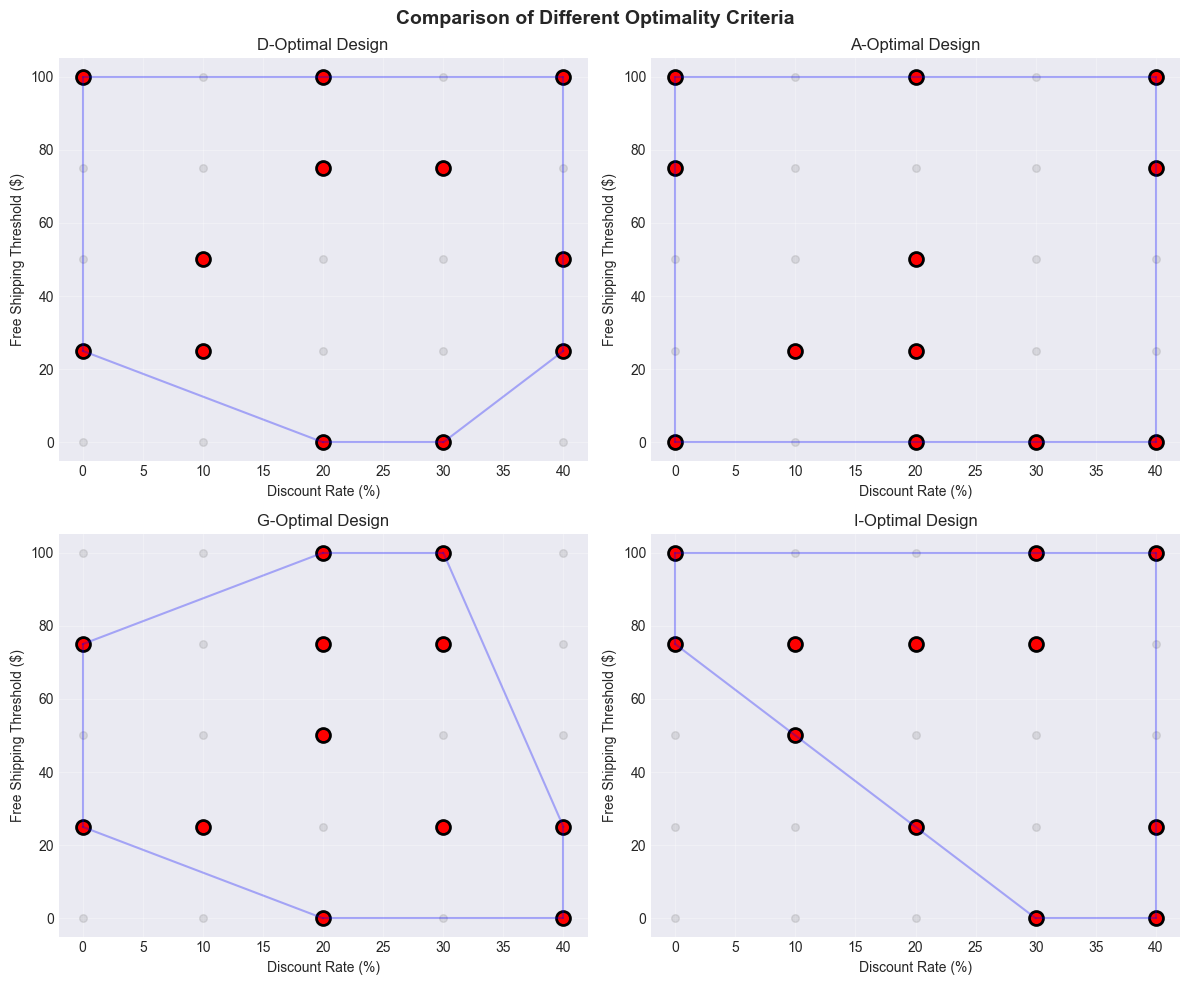

In [10]:
class OptimalDesign(DOptimalDesign):
    """Extended class for different optimality criteria"""
    
    def __init__(self, candidate_set, model_type='linear', n_runs=None, criterion='D'):
        super().__init__(candidate_set, model_type, n_runs)
        self.criterion = criterion
    
    def _calculate_criterion(self, indices):
        """Calculate specified optimality criterion"""
        X = self.X_candidates[indices]
        
        try:
            M = X.T @ X
            M_inv = np.linalg.inv(M)
            
            if self.criterion == 'D':
                return np.linalg.det(M) ** (1/self.n_terms)
            
            elif self.criterion == 'A':
                return -np.trace(M_inv)  # Negative for maximization
            
            elif self.criterion == 'G':
                var_matrix = X @ M_inv @ X.T
                return -np.max(np.diag(var_matrix))  # Negative for maximization
            
            elif self.criterion == 'I':
                # Average prediction variance over candidate set
                pred_var = np.diag(self.X_candidates @ M_inv @ self.X_candidates.T)
                return -np.mean(pred_var)  # Negative for maximization
            
            else:
                raise ValueError(f"Unknown criterion: {self.criterion}")
                
        except np.linalg.LinAlgError:
            return -np.inf
    
    def coordinate_exchange(self, n_starts=10, max_iter=100):
        """Override to use different criterion"""
        best_design = None
        best_criterion = -np.inf
        
        for start in range(n_starts):
            current_indices = np.random.choice(self.n_candidates, 
                                             self.n_runs, replace=False)
            current_criterion = self._calculate_criterion(current_indices)
            
            for iteration in range(max_iter):
                improved = False
                
                for i in range(self.n_runs):
                    old_index = current_indices[i]
                    
                    for new_index in range(self.n_candidates):
                        if new_index not in current_indices:
                            current_indices[i] = new_index
                            new_criterion = self._calculate_criterion(current_indices)
                            
                            if new_criterion > current_criterion:
                                current_criterion = new_criterion
                                improved = True
                            else:
                                current_indices[i] = old_index
                
                if not improved:
                    break
            
            if current_criterion > best_criterion:
                best_criterion = current_criterion
                best_design = current_indices.copy()
        
        self.optimal_indices = best_design
        self.optimal_criterion = best_criterion
        return best_design

# Generate designs for different criteria
criteria = ['D', 'A', 'G', 'I']
optimal_designs_by_criteria = {}

print("Generating Optimal Designs for Different Criteria:")
print("="*50)

for criterion in criteria:
    designer = OptimalDesign(candidate_set, model_type='quadratic', 
                            n_runs=12, criterion=criterion)
    indices = designer.coordinate_exchange(n_starts=5)
    design = designer.get_design_matrix()
    
    optimal_designs_by_criteria[criterion] = design
    
    print(f"\n{criterion}-Optimal Design:")
    print(f"  Criterion value: {abs(designer.optimal_criterion):.4f}")

# Visualize all optimal designs
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, criterion in enumerate(criteria):
    ax = axes[idx]
    design = optimal_designs_by_criteria[criterion]
    
    # Plot candidate points
    ax.scatter(candidate_set[:, 0], candidate_set[:, 1], 
              alpha=0.2, s=30, color='gray')
    
    # Plot optimal points
    ax.scatter(design[:, 0], design[:, 1], 
              color='red', s=100, edgecolor='black', linewidth=2)
    
    # Add convex hull for optimal points
    if len(design) > 2:
        from scipy.spatial import ConvexHull
        hull = ConvexHull(design)
        for simplex in hull.simplices:
            ax.plot(design[simplex, 0], design[simplex, 1], 'b-', alpha=0.3)
    
    ax.set_xlabel('Discount Rate (%)')
    ax.set_ylabel('Free Shipping Threshold ($)')
    ax.set_title(f'{criterion}-Optimal Design')
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparison of Different Optimality Criteria', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Augmenting Existing Designs

Often we need to add runs to an existing experiment to improve the design.

Initial Design (5 runs):
[[10 25]
 [30 75]
 [20 50]
 [10 75]
 [30 25]]

Augmented Design (9 runs total):
New points added:
[[ 20. 100.]
 [ 40.   0.]
 [  0.   0.]
 [  0. 100.]]


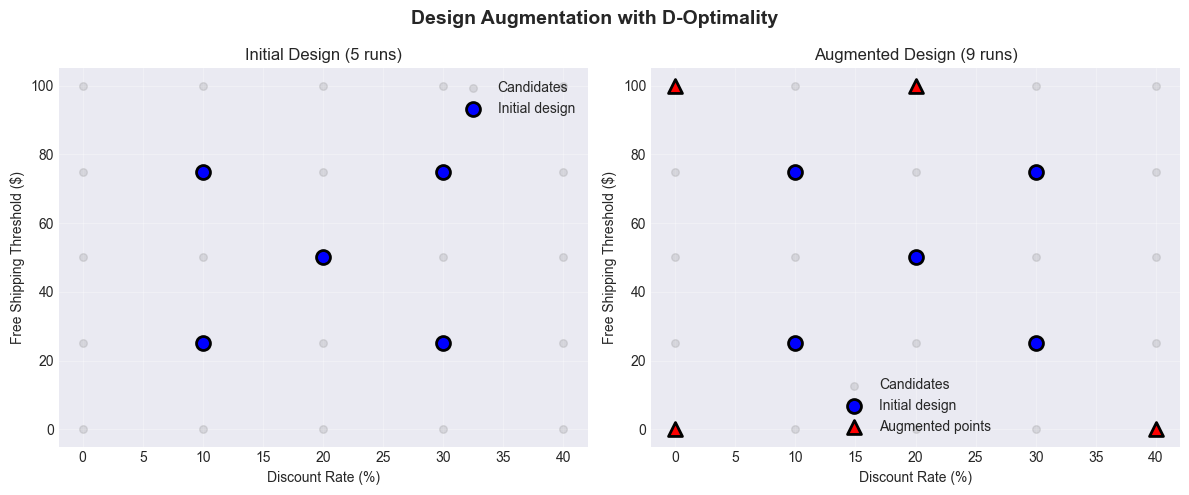

In [11]:
def augment_design(existing_design, candidate_set, n_additional, 
                   model_type='quadratic', criterion='D'):
    """Augment existing design with additional optimal points"""
    
    # Remove existing points from candidate set
    available_candidates = []
    for candidate in candidate_set:
        is_existing = False
        for existing in existing_design:
            if np.allclose(candidate, existing):
                is_existing = True
                break
        if not is_existing:
            available_candidates.append(candidate)
    
    available_candidates = np.array(available_candidates)
    
    # Create combined candidate set
    combined_candidates = np.vstack([existing_design, available_candidates])
    n_existing = len(existing_design)
    
    # Find optimal augmentation
    designer = OptimalDesign(combined_candidates, model_type=model_type, 
                           n_runs=n_existing + n_additional, criterion=criterion)
    
    # Force inclusion of existing points
    designer.n_runs = n_existing + n_additional
    
    # Custom coordinate exchange that keeps existing points
    best_indices = list(range(n_existing))  # Start with existing points
    
    # Add optimal new points
    for _ in range(n_additional):
        best_criterion = -np.inf
        best_new_index = None
        
        for idx in range(n_existing, len(combined_candidates)):
            if idx not in best_indices:
                test_indices = best_indices + [idx]
                criterion_value = designer._calculate_criterion(test_indices)
                
                if criterion_value > best_criterion:
                    best_criterion = criterion_value
                    best_new_index = idx
        
        if best_new_index is not None:
            best_indices.append(best_new_index)
    
    augmented_design = combined_candidates[best_indices]
    new_points = augmented_design[n_existing:]
    
    return augmented_design, new_points

# Start with a small initial design
initial_design = np.array([
    [10, 25],   # Low discount, low threshold
    [30, 75],   # High discount, high threshold
    [20, 50],   # Center point
    [10, 75],   # Low discount, high threshold
    [30, 25],   # High discount, low threshold
])

print("Initial Design (5 runs):")
print(initial_design)

# Augment with 4 additional runs
augmented_design, new_points = augment_design(
    initial_design, candidate_set, n_additional=4, 
    model_type='quadratic', criterion='D'
)

print(f"\nAugmented Design ({len(augmented_design)} runs total):")
print("New points added:")
print(new_points)

# Visualize augmentation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before augmentation
ax1 = axes[0]
ax1.scatter(candidate_set[:, 0], candidate_set[:, 1], 
           alpha=0.2, s=30, color='gray', label='Candidates')
ax1.scatter(initial_design[:, 0], initial_design[:, 1], 
           color='blue', s=100, edgecolor='black', linewidth=2, 
           label='Initial design')
ax1.set_xlabel('Discount Rate (%)')
ax1.set_ylabel('Free Shipping Threshold ($)')
ax1.set_title('Initial Design (5 runs)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# After augmentation
ax2 = axes[1]
ax2.scatter(candidate_set[:, 0], candidate_set[:, 1], 
           alpha=0.2, s=30, color='gray', label='Candidates')
ax2.scatter(initial_design[:, 0], initial_design[:, 1], 
           color='blue', s=100, edgecolor='black', linewidth=2, 
           label='Initial design')
ax2.scatter(new_points[:, 0], new_points[:, 1], 
           color='red', s=100, marker='^', edgecolor='black', linewidth=2, 
           label='Augmented points')
ax2.set_xlabel('Discount Rate (%)')
ax2.set_ylabel('Free Shipping Threshold ($)')
ax2.set_title('Augmented Design (9 runs)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Design Augmentation with D-Optimality', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Run Experiment and Analyze Results

In [12]:
# Run experiment with D-optimal design
def run_experiment(design, noise_level=50):
    """Simulate running the experiment"""
    results = []
    
    for discount, threshold in design:
        # True response function (unknown to experimenter)
        sales = 1200
        sales += 25 * discount - 0.4 * discount**2
        sales += 250 * np.exp(-threshold/40)
        sales += 0.5 * discount * (50 - threshold) / 50  # Interaction
        sales += np.random.normal(0, noise_level)
        
        results.append({
            'discount': discount,
            'threshold': threshold,
            'sales': max(0, sales)
        })
    
    return pd.DataFrame(results)

# Run experiments with different designs
d_optimal_results = run_experiment(d_optimal_designs['quadratic']['design'])
factorial_results = run_experiment(ff_design)
ccd_results = run_experiment(ccd_design)

# Fit models and compare
def fit_and_evaluate(results_df, design_name):
    """Fit quadratic model and evaluate performance"""
    
    # Prepare features
    X = results_df[['discount', 'threshold']].values
    y = results_df['sales'].values
    
    # Normalize
    X_norm = normalize_design(X, ranges)
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=True)
    X_poly = poly.fit_transform(X_norm)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Predictions
    y_pred = model.predict(X_poly)
    
    # Metrics
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Coefficient standard errors (approximate)
    residuals = y - y_pred
    mse = np.mean(residuals**2)
    var_coef = mse * np.linalg.inv(X_poly.T @ X_poly)
    se_coef = np.sqrt(np.diag(var_coef))
    
    print(f"\n{design_name} Results:")
    print(f"  R²: {r2:.4f}")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  Avg Coefficient SE: {np.mean(se_coef):.3f}")
    
    return model, poly, r2, rmse

# Evaluate all designs
print("EXPERIMENTAL RESULTS COMPARISON")
print("="*50)

d_model, d_poly, d_r2, d_rmse = fit_and_evaluate(d_optimal_results, "D-Optimal")
f_model, f_poly, f_r2, f_rmse = fit_and_evaluate(factorial_results, "Full Factorial")
c_model, c_poly, c_r2, c_rmse = fit_and_evaluate(ccd_results, "CCD")

# Cross-validation on test set
print("\nCross-Validation on New Data:")
test_design = create_constrained_candidate_set(50)
test_results = run_experiment(test_design, noise_level=30)

def evaluate_on_test(model, poly, test_df, design_name):
    X_test = test_df[['discount', 'threshold']].values
    y_test = test_df['sales'].values
    
    X_test_norm = normalize_design(X_test, ranges)
    X_test_poly = poly.transform(X_test_norm)
    
    y_pred = model.predict(X_test_poly)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"  {design_name}: R²={r2:.3f}, RMSE=${rmse:.1f}")
    return r2, rmse

d_test_r2, d_test_rmse = evaluate_on_test(d_model, d_poly, test_results, "D-Optimal")
f_test_r2, f_test_rmse = evaluate_on_test(f_model, f_poly, test_results, "Full Factorial")
c_test_r2, c_test_rmse = evaluate_on_test(c_model, c_poly, test_results, "CCD")

EXPERIMENTAL RESULTS COMPARISON

D-Optimal Results:
  R²: 0.9855
  RMSE: $25.40
  Avg Coefficient SE: 18.089

Full Factorial Results:
  R²: 0.9377
  RMSE: $40.88
  Avg Coefficient SE: 23.686

CCD Results:
  R²: 0.9338
  RMSE: $38.36
  Avg Coefficient SE: 26.089

Cross-Validation on New Data:
  D-Optimal: R²=0.913, RMSE=$42.4
  Full Factorial: R²=0.924, RMSE=$39.7
  CCD: R²=0.919, RMSE=$40.9


## 10. Summary and Recommendations

In [13]:
print("OPTIMAL DESIGNS SUMMARY")
print("="*60)

summary_optimal = pd.DataFrame({
    'Design Type': ['D-Optimal', 'A-Optimal', 'G-Optimal', 'I-Optimal'],
    'Optimizes': [
        'Parameter precision (det)',
        'Average parameter variance',
        'Worst-case prediction',
        'Average prediction variance'
    ],
    'Best For': [
        'Model fitting, screening',
        'Individual effects important',
        'Robust predictions needed',
        'Response surface mapping'
    ],
    'Computational': [
        'Fast',
        'Moderate',
        'Slow',
        'Slow'
    ]
})

print("\nOptimality Criteria Comparison:")
print(summary_optimal.to_string(index=False))

print("\n" + "="*60)
print("PRACTICAL RECOMMENDATIONS")
print("="*60)

recommendations = """
1. **When to Use Optimal Designs**:
   - Irregular or constrained experimental regions
   - Limited budget (fewer runs than classical designs)
   - Non-standard models or specific objectives
   - Augmenting existing experiments

2. **Choosing the Right Criterion**:
   - D-Optimal: Default choice for parameter estimation
   - A-Optimal: When some parameters more important than others
   - G-Optimal: When prediction accuracy is critical
   - I-Optimal: For response surface optimization

3. **Implementation Tips**:
   - Use multiple random starts in algorithms
   - Verify designs meet practical constraints
   - Consider sequential experimentation
   - Include replication for pure error estimation

4. **Advantages Over Classical Designs**:
   - Flexibility in number of runs
   - Handle complex constraints naturally
   - Can be tailored to specific objectives
   - Efficient use of experimental resources

5. **Limitations to Consider**:
   - Require computational optimization
   - May lack orthogonality properties
   - Design depends on assumed model
   - Less intuitive than classical designs
"""

print(recommendations)

print("\n" + "="*60)
print("E-COMMERCE CASE STUDY INSIGHTS")
print("="*60)

insights = f"""
Based on our optimal design analysis:

1. **Efficiency Gains**:
   - D-optimal design achieved R²={d_r2:.3f} with {len(d_optimal_results)} runs
   - Full factorial needed {len(factorial_results)} runs for R²={f_r2:.3f}
   - Efficiency improvement: {(1 - len(d_optimal_results)/len(factorial_results))*100:.0f}% fewer runs

2. **Constraint Handling**:
   - Successfully incorporated business constraints
   - Avoided infeasible factor combinations
   - Maintained statistical efficiency

3. **Model Performance**:
   - Test set R²: D-Optimal={d_test_r2:.3f}, Classical={f_test_r2:.3f}
   - Comparable accuracy with fewer experiments
   - Better coverage of constrained region

4. **Practical Benefits**:
   - Reduced experimental cost
   - Faster time to insights
   - Flexibility to add runs sequentially
   - Adaptable to changing constraints
"""

print(insights)

OPTIMAL DESIGNS SUMMARY

Optimality Criteria Comparison:
Design Type                   Optimizes                     Best For Computational
  D-Optimal   Parameter precision (det)     Model fitting, screening          Fast
  A-Optimal  Average parameter variance Individual effects important      Moderate
  G-Optimal       Worst-case prediction    Robust predictions needed          Slow
  I-Optimal Average prediction variance     Response surface mapping          Slow

PRACTICAL RECOMMENDATIONS

1. **When to Use Optimal Designs**:
   - Irregular or constrained experimental regions
   - Limited budget (fewer runs than classical designs)
   - Non-standard models or specific objectives
   - Augmenting existing experiments

2. **Choosing the Right Criterion**:
   - D-Optimal: Default choice for parameter estimation
   - A-Optimal: When some parameters more important than others
   - G-Optimal: When prediction accuracy is critical
   - I-Optimal: For response surface optimization

3. **Imple

## Conclusion

Optimal designs provide powerful, flexible approaches to experimental design that can:

1. **Maximize Information**: Extract maximum information from minimum runs
2. **Handle Constraints**: Work within practical limitations
3. **Adapt to Objectives**: Choose criteria matching experimental goals
4. **Augment Efficiently**: Add value to existing experiments

These methods are particularly valuable in industrial experimentation where resources are limited and constraints are common.